# Ryan Burger:Final Cosmetics Analysis 

## Introduction: 

### There is 4,416 cosmetic business in the US in 2023 which has increase 4.7% since 2022. This sector is growing and many people are joining it and need guidance on how to price there products based on what customers are willing to pay to increase the companies revenue. I found a dataset on kaggle to help anwer this question for the companies, did analysis on the data, created models to help explain and wrapped it together with the final price point. 

### Exploratory Data Analysis 

I started with EDA because I needed to have a better understanding of the data as well as delete any empty or not important infromation from my dataset. My first step of EDA was importing the libraries that I would be using in my analysis.

In [1]:
#Importing libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import squarify 
import matplotlib.dates as dates 
from datetime import datetime
import xgboost as xgboost 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.model_selection import KFold 
from xgboost import XGBClassifier 
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

### Ecommerce Data

In [2]:
#Read in the dataset as a csv file 
data = pd.read_csv('commerce_data.csv')

In [3]:
#New dataframe create with only the columns that be used to create my model 
df = data.drop(['time', 'product_id','category_id', 'category_name', 'brand', 'user_id', 'session', 'category_1',
               'category_2', 'category_3'], axis =1)
df.head()

,event_name,price
0,view,26.97
1,view,24.44
2,view,55.56
3,view,29.71
4,view,1.11


In [4]:
#Checking to see if there are any null values in my new dataframe 
df.isnull().sum()

event_name    0
price         0
dtype: int64

In [5]:
#Checking the data types of the columns in the dataset 
df.dtypes

event_name     object
price         float64
dtype: object

#### Deleting any price that had a value of $0 was done here so that the data was only tested on items that would return a profit

In [6]:
df = df[df.price != 0]
df.head()
df.count()

event_name    3525697
price         3525697
dtype: int64

In [7]:
#Checking to see if all the price that are equal to $0 were removed from the dataset
found = df['price'].isin([0])
df1 = pd.DataFrame({'price': found})
df1['price'].value_counts()

False    3525697
Name: price, dtype: int64

#### Removing event name values that were equal to view and cart were removed since they do not have a tangible impact on profit

In [8]:
df = df[df.event_name != 'cart']
df = df[df.event_name != 'view']
df.head(100)

,event_name,price
8,remove_from_cart,4.16
10,remove_from_cart,1.11
11,purchase,1.27
12,purchase,24.60
22,remove_from_cart,24.60
...,...,...
594,remove_from_cart,24.44
595,remove_from_cart,24.44
597,remove_from_cart,46.83
598,remove_from_cart,46.83


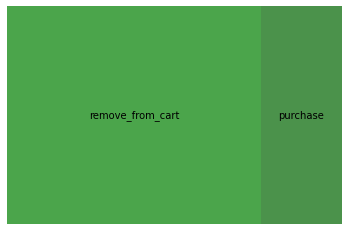

In [9]:
#Create a graphic to show how many people removed and item from their cart versus purchased it
top_event = df.loc[:,'event_name'].value_counts().sort_values(ascending=False)
squarify.plot(sizes=top_event, label = top_event.index.array, color=["green","darkgreen"], alpha=.7)
plt.axis('off')
plt.show()

## Machine Learning Model #1: XGBoost 

### When creating my XGBoost model I took ten steps to create the model: 
    1) Isolated the X and Y variables
    2) Split the dataset into training and test sets 
    3) Transform the items in the event_name column to integers 
    4) Create matrices to show the true negatives and positives, as well as, false negatives and positives 
    5) Set parameters for model and run the model 
    6) Create prediction parameters 
    7) Create Confusion matrix 
    8) Isolate categorical variables and turn them into dummy variables 
    9) Create a classifier 
    10) Find F1 accuracy score 

##### 1) 

In [10]:
# Isolate the X and Y varaibles 
y = df.iloc[:,0]
x = df._get_numeric_data()

##### 2)

In [11]:
#Split dataset into training and test set 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .9, random_state = 3525696 )

##### 3)

In [12]:
#Transform y factor to variable 
y_train = np.where(y_train == 'remove_from_cart', 1, 0)
y_test = np.where(y_test == 'remove_from_cart', 1, 0)

##### 4)

In [13]:
#Create xgboost matrices 
Train = xgboost.DMatrix(x_train, label = y_train)
Test = xgboost.DMatrix(x_test, label = y_test)

##### 5)

In [14]:
#Setting parameters 
parameters1 = {'learning_rate': 0.3, 
              'max_depth': 2,
              'colsample_bytree': 1, 
               'subsample': 1, 
               'min_child_weight': 1,
               'gamma' : 0,
               'random_state' : 3525696, 
               'eval_metric': 'auc',
               'objective': 'binary:logistic'}

In [15]:
#Run xgboost 
model1 = xgboost.train(params = parameters1, 
                      dtrain = Train, 
                      num_boost_round = 200, 
                      evals = [(Test, 'Yes')],
                      verbose_eval = 50)

[0]	Yes-auc:0.53300
[50]	Yes-auc:0.55773
[100]	Yes-auc:0.56085
[150]	Yes-auc:0.56179
[199]	Yes-auc:0.56261


##### 6)

In [16]:
#Prediction parameters 
predictions1 = model1.predict(Test)
predictions1 = np.where(predictions1 > 0.8, 1, 0)

##### 7)

In [17]:
#Confusion Matrix 
matrix1 = confusion_matrix(y_test, predictions1)

In [18]:
#Create confusion plot 
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
                # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

conf_matrix(y_test, predictions1)

{'TP': 92689, 'TN': 170645, 'FP': 21214, 'FN': 505217}

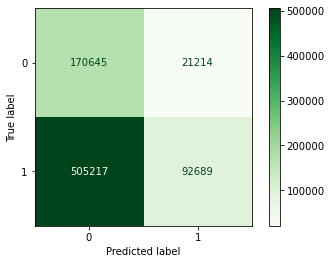

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix1)
disp.plot(cmap=plt.cm.Greens)

##### 8)

In [20]:
#Isolate categorical variables 
dataset_categorical = df.select_dtypes(exclude = 'number')

In [21]:
#Transform categorical variables into dummy variables 
dataset_categorical = pd.get_dummies(data = dataset_categorical,
                                    drop_first = True)
dataset_categorical.head()

,event_name_remove_from_cart
8,1
10,1
11,0
12,0
22,1


##### 9)

In [22]:
#Create classifier 
classifier = XGBClassifier(learning_rate = 0.1)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

##### 10) 

In [23]:
#Find f1 score 
y_pred_basemodel = classifier.predict(x_test)
print('F1 score for the base model is: ',f1_score(y_test,y_pred_basemodel))

F1 score for the base model is:  0.8617402828191985


## Logistic Regression

#### Since I already isolated the X and Y varaibles in the XGBoost model I do not need to do it again and was able to create this model in only 5 steps
    1) Split the data into training and test set 
    2) Scale data 
    3) Create a model and train it 
    4) Evaluate the model 
    5) Create confusion matrix
    6) Find the accuracy score 

##### 1) 

In [24]:
#Split dataset into training and test set 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .9, random_state = 3525696 )

##### 2) 

In [25]:
#Scale Data 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

##### 3) 

In [26]:
#Create model and train it 
model2 = LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr',
                           random_state=0)
model2.fit(x_train, y_train)

LogisticRegression(C=0.05, multi_class='ovr', random_state=0,
                   solver='liblinear')

##### 4)

In [27]:
#Evaluate the model 
x_test = scaler.transform(x_test)
y_pred = model2.predict(x_test)

##### 5) 

In [28]:
#Create confusion matrix 
matrix2 = confusion_matrix(y_test, y_pred)
matrix2

array([[     0, 191859],
       [     0, 597906]], dtype=int64)

In [29]:
#Create confusion plot 
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
                # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

conf_matrix(y_train, y_pred)

{'TP': 0, 'TN': 66434, 'FP': 21317, 'FN': 0}

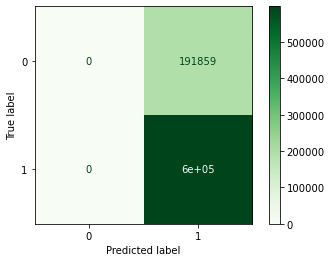

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix2)
disp.plot(cmap=plt.cm.Greens)

##### 6) 

In [31]:
#Obtain score 
print(model2.score(x_train, y_train))
model2.score(x_test, y_test)

0.757073993458764


0.7570682418187689

## Business Understanding

### This part is helpful in tying back the analysis to the business problem at hand. First, I combined the price and numerical remove from cart values into one table. Second, I binned the prices in groups of 50 to have a better idea of how many times each even occured in each bin. Lastly, I did a few calculations and created two graphs to get my final reccomendation. 

In [32]:
#Joining numerical and categorical datasets 
final_dataset = pd.concat((x, dataset_categorical), axis = 1)
final_dataset

,price,event_name_remove_from_cart
8,4.16,1
10,1.11,1
11,1.27,0
12,24.60,0
22,24.60,1
...,...,...
3533270,24.60,1
3533271,24.60,1
3533272,1.11,1
3533278,82.54,1


In [33]:
#Binning the data for prodcuts $0-$50 and grouping the bins by 0 and 1
bins = [0,50]
final_dataset['binned'] = pd.cut(final_dataset['price'], bins)
final_dataset
# print(final_dataset.count())
final1= final_dataset.groupby(['binned','event_name_remove_from_cart'])
final1.count()

price
binned  event_name_remove_from_cart        
(0, 50] 0                            211921
        1                            660029

In [34]:
#Binning the data for prodcuts $50-200 and grouping the bins by 0 and 1
bins = [50,100,150,200]
final_dataset['binned'] = pd.cut(final_dataset['price'], bins)
final_dataset
# print(final_dataset.count())
final2= final_dataset.groupby(['binned','event_name_remove_from_cart'])
final2.count()

price
binned     event_name_remove_from_cart       
(50, 100]  0                              949
           1                             3089
(100, 150] 0                              151
           1                              578
(150, 200] 0                              106
           1                              377

In [35]:
#Binning the data for prodcuts $200-350 and grouping the bins by 0 and 1
bins = [200,250,300,350]
final_dataset['binned'] = pd.cut(final_dataset['price'], bins)
final_dataset
# print(final_dataset.count())
final3= final_dataset.groupby(['binned','event_name_remove_from_cart'])
final3.count()

price
binned     event_name_remove_from_cart       
(200, 250] 0                               16
           1                              128
(250, 300] 0                               13
           1                              127
(300, 350] 0                                2
           1                               12

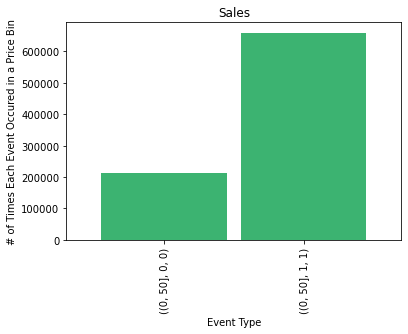

In [36]:
#Creating a graph for $0-$50 price bucket
fig, ax = plt.subplots()
final1['event_name_remove_from_cart'].value_counts().plot(kind = 'bar', width = 0.9,y="price", ax=ax, color='mediumseagreen');
plt.title('Sales')
plt.ylabel('# of Times Each Event Occured in a Price Bin')
plt.xlabel('Event Type')
plt.show()

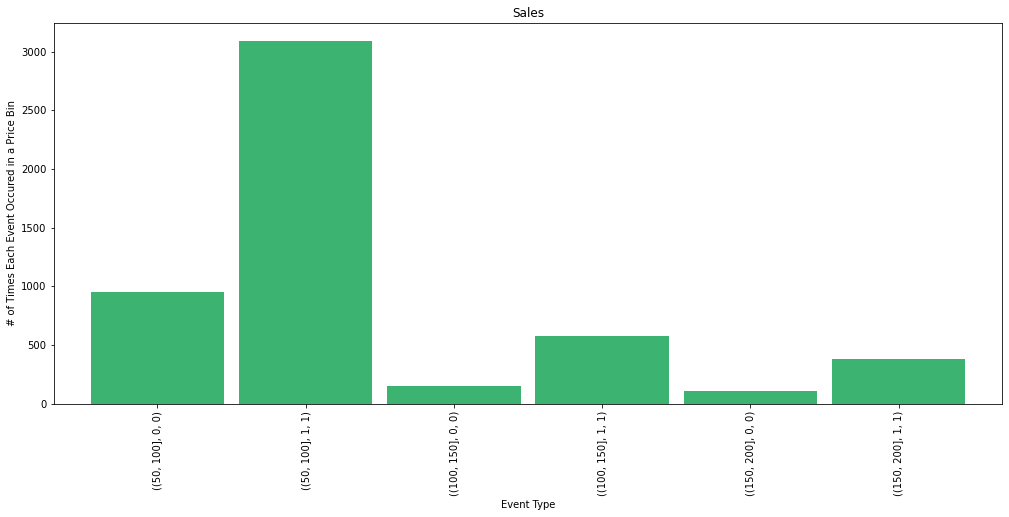

In [37]:
#Creating a graph for $50-$200 price bucket
fig, ax = plt.subplots(figsize=(17,7))
final2['event_name_remove_from_cart'].value_counts().plot(kind = 'bar',width = 0.9,y="price", ax=ax, color='mediumseagreen');

plt.title('Sales')
plt.ylabel('# of Times Each Event Occured in a Price Bin')
plt.xlabel('Event Type')
plt.show()

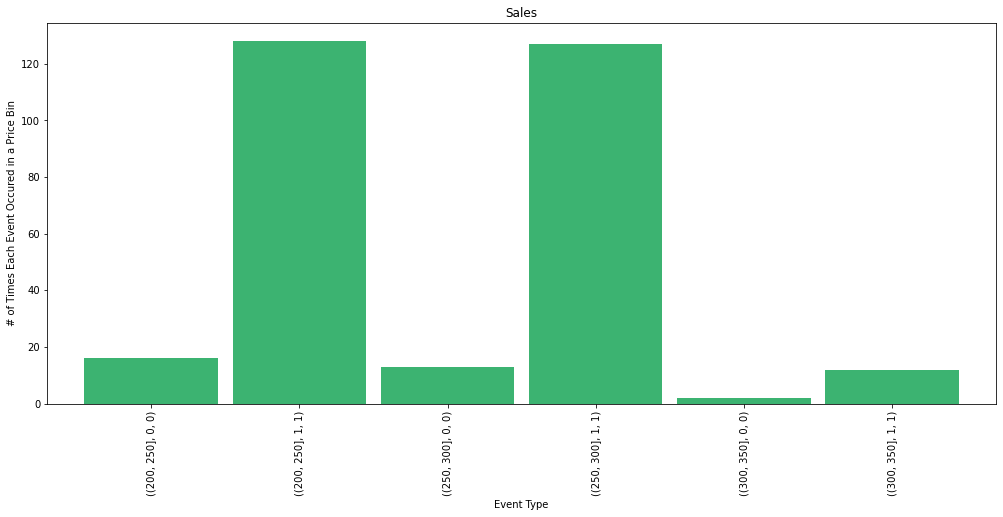

In [38]:
#Creating a graph for $200-$250 price bucket
fig, ax = plt.subplots(figsize=(17,7))
final3['event_name_remove_from_cart'].value_counts().plot(kind = 'bar',width = 0.9,y="price", ax=ax, color='mediumseagreen');

plt.title('Sales')
plt.ylabel('# of Times Each Event Occured in a Price Bin')
plt.xlabel('Event Type')
plt.show()

In [39]:
#Calculating the percentage of each bin in the means of 0 and 1's
print(211921/(211921+660029))
print(949/(949+3089))
print(151/(578+151))
print(106/(106+377))
print(16/(16+128))
print(13/(13+127))
print(2/(2+12))

0.2430426056539939
0.23501733531451213
0.20713305898491083
0.2194616977225673
0.1111111111111111
0.09285714285714286
0.14285714285714285


# Conclusion 

#### After concluding my analysis and modeling, my recommendation for cosmetic comapnies is to sell items at or below $200. 